#  Investigate sequence diversity of esterases using MMSeqs2

### Run MMSeqs2 on promiscuous esterase dataset

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

df_promis_esterases = pd.read_pickle('data/EnzymeCAGE_train_promiscuous_substrates_EC3p1.pkl')

In [ ]:
import sys
sys.path.append('/home/helen/enzyme-tk/enzymetk')
from enzymetk.similarity_mmseqs_step import MMseqs
from enzymetk.save_step import Save
import pandas as pd

# run in enzymetk environemnt
id_col = 'UniprotID'
seq_col = 'sequence'
output_dir = 'mmseqs2/'

df_promis_esterases << (MMseqs(id_col, seq_col, tmp_dir=output_dir, method='cluster',  args=['--min-seq-id', '0.9', '-c', '0.8', '--cov-mode', '1']) >> Save(f'{output_dir}promiscuous_esterases_mmseqs2_0p9_similarity.pkl'))
df_promis_esterases << (MMseqs(id_col, seq_col, tmp_dir=output_dir, method='cluster',  args=['--min-seq-id', '0.6', '-c', '0.8', '--cov-mode', '1']) >> Save(f'{output_dir}promiscuous_esterases_mmseqs2_0p6_similarity.pkl'))
df_promis_esterases << (MMseqs(id_col, seq_col, tmp_dir=output_dir, method='cluster',  args=['--min-seq-id', '0.4', '-c', '0.8', '--cov-mode', '1']) >> Save(f'{output_dir}promiscuous_esterases_mmseqs2_0p4_similarity.pkl'))

### Embed protein sequences using ESM2

In [4]:
import sys
from enzymetk.embedprotein_esm_step import EmbedESM
from enzymetk.save_step import Save
import pandas as pd

# run in enzymetk environemnt
df_promis_esterases = pd.read_pickle('data/EnzymeCAGE_train_promiscuous_substrates_EC3p1.pkl')
df_filtered = df_promis_esterases.drop_duplicates(subset='UniprotID', keep='first')
id_col = 'UniprotID'
seq_col = 'sequence'
output_dir = 'esm2/'

df_filtered << (EmbedESM(id_col, seq_col, extraction_method='mean', tmp_dir=output_dir) >> Save(f'{output_dir}promiscuous_esterases_esm2_embedded_v2.pkl'))

--------------------------------------------------------------------------------
Running command	conda run -n enzymetk python /home/helen/miniconda3/envs/enzymetk/lib/python3.11/site-packages/enzymetk/esm-extract.py esm2_t33_650M_UR50D esm2//input.fasta esm2/ --include per_tok	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                                    Output:	                                    
--------------------------------------------------------------------------------
Transferred model to GPU
Read esm2/input.fasta with 2643 sequences
Processing 1 of 237 batches (28 sequences)
Processing 2 of 237 batches (28 sequences)
Processing 3 of 237 batches (28 sequences)
Processing 4 of 237 batches (28 sequences)
Processing 5 of 237 batches (28 sequences)
Processing 6 of 237 batches (28 sequences)
Processing 7 of 237 batches (28 sequences)
Processing 8 of 237 batches (

100%|██████████| 2643/2643 [00:03<00:00, 876.60it/s]
/home/helen/miniconda3/envs/enzymetk/lib/python3.11/site-packages/enzymetk/embedprotein_esm_step.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['embedding'] = tensors


0 0 0


,RHEA_ID,DIRECTION,MASTER_ID,UniprotID,SMILES,EC number,CANO_RXN_SMILES,sequence,reverse_template,n_seq,...,key,direct_weight,rank_weight_light,rank_weight_hard,substrates,products,number_substrates,number_products,substrates_split,embedding
0,53744,UN,53744,A0A023W421,*P(=O)([O-])OC[C@H]1O[C@@H](N2C=NC3=C(N)N=CN=C...,3.1.1.96,*P(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H...,MKLVVQRVTDASVTVDGAVAGRIGPGIMALVGVTHEDTEEDAAYLA...,[C:4]-[C;H0;D3;+0:3](-[O-;H0;D1:6])=[O;D1;H0:5...,147,...,*P(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H...,0.758806,0.9,0.500000,*P(=O)([O-])OC[C@H]1O[C@@H](N2C=NC3=C(N)N=CN=C...,*P(=O)([O-])OC[C@H]1O[C@@H](N2C=NC3=C(N)N=CN=C...,1,3,*P(=O)([O-])OC[C@H]1O[C@@H](N2C=NC3=C(N)N=CN=C...,"[0.02359803, -0.0028808287, 0.0125321625, 0.00..."
2,45632,UN,45632,A0A0G2JXT6,CCCCCCCC(=O)OC[C@H](COP(=O)([O-])O[C@@H]1[C@H]...,3.1.3.95,CCCCCCCC(=O)OC[C@H](COP(=O)(O)O[C@@H]1[C@H](O)...,MEHIRTTKVEQVKLLDRFSTNNKSLTGTLYLTATHLLFIDAHQKET...,[C:1]-[OH;D1;+0:2].[O;-;D1;H0:4]-[P;H0;D4;+0:3...,655,...,CCCCCCCC(=O)OC[C@H](COP(=O)(O)O[C@@H]1[C@H](O)...,0.856662,0.6,0.200000,CCCCCCCC(=O)OC[C@H](COP(=O)([O-])O[C@@H]1[C@H]...,CCCCCCCC(=O)OC[C@H](COP(=O)([O-])O[C@H]1[C@H](...,1,2,CCCCCCCC(=O)OC[C@H](COP(=O)([O-])O[C@@H]1[C@H]...,"[0.01086533, -0.036436066, 0.023325494, 0.0449..."
6,60388,UN,60388,A0A0H2V660,[H][C@]12COC(=O)[C@]3([H])COC(=O)[C@]([H])(COC...,3.1.1.109,O.O=C1N[C@H]2COC(=O)[C@@H]3COC(=O)[C@H](COC2=O...,MIDKNQTCGVGQDSVPYMICLIHILEEWFGVEQLEDYLNFANYLLW...,[#7:1]-[C:2]-[C;H0;D3;+0:3](-[O-;H0;D1:7])=[O;...,324,...,O.O=C1N[C@H]2COC(=O)[C@@H]3COC(=O)[C@H](COC2=O...,0.712541,1.0,1.000000,[H][C@]12COC(=O)[C@]3([H])COC(=O)[C@]([H])(COC...,O=C1N[C@H](C(=O)[O-])COC(=O)[C@@H]2COC(=O)[C@H...,1,2,[H][C@]12COC(=O)[C@]3([H])COC(=O)[C@]([H])(COC...,"[-0.027480608, -0.11780349, -0.05612977, 0.079..."
10,59264,UN,59264,A0A0H2V760,O=C1N[C@H](C(=O)[O-])COC(=O)[C@H](CO)NC(=O)C2=...,3.1.1.108,O.O=C1N[C@H](C(=O)O)COC(=O)[C@H](CO)NC(=O)c2cc...,MIDKNQTCGVGQDSVPYMICLIHILEEWFGVEQLEDYLNFANYLLW...,[#7:1]-[C:2]-[C;H0;D3;+0:3](-[O-;H0;D1:14])=[O...,324,...,O.O=C1N[C@H](C(=O)O)COC(=O)[C@H](CO)NC(=O)c2cc...,0.816346,1.0,1.000000,O=C1N[C@H](C(=O)[O-])COC(=O)[C@H](CO)NC(=O)C2=...,O=C(N[C@@H](CO)C(=O)[O-])C1=C2O[Fe+]OC2=CC=C1....,2,2,O=C1N[C@H](C(=O)[O-])COC(=O)[C@H](CO)NC(=O)C2=...,"[-0.027480608, -0.11780349, -0.05612977, 0.079..."
17,60413,LR,60412,A0A0H2V871,O=C(N[C@H]1COC(=O)[C@@H](NC(=O)C2=CC=CC(O)=C2O...,3.1.1.107,O.O=C(N[C@H]1COC(=O)[C@@H](NC(=O)c2cccc(O)c2O)...,MYAREYRSTRPHKAIFFHLSCLTLICSAQVYAKPDMRPLGPNIADK...,NaN,318,...,O.O=C(N[C@H]1COC(=O)[C@@H](NC(=O)c2cccc(O)c2O)...,0.750610,1.0,1.000000,O=C(N[C@H]1COC(=O)[C@@H](NC(=O)C2=CC=CC(O)=C2O...,O=C(N[C@@H](COC(=O)[C@H](COC(=O)[C@H](CO)NC(=O...,1,2,O=C(N[C@H]1COC(=O)[C@@H](NC(=O)C2=CC=CC(O)=C2O...,"[0.024387136, -0.027107583, 0.04585238, 0.0170..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9559,20629,UN,20629,Q9ZV25,*N[C@@H](COP(=O)([O-])[O-])C(*)=O.[H]O[H]>>*N[...,3.1.3.16,*N[C@@H](COP(=O)(O)O)C(*)=O.O>>*N[C@@H](CO)C(*...,MGNGIGKLSKCLTGGAGRNKKPELSILEPDPLDEGLGHSFCYVRPD...,NaN,654,...,*N[C@@H](COP(=O)(O)O)C(*)=O.O>>*N[C@@H](CO)C(*...,0.704179,0.7,0.250000,*N[C@@H](COP(=O)([O-])[O-])C(*)=O,*N[C@@H](CO)C(*)=O.O=P([O-])([O-])O,1,2,*N[C@@H](COP(=O)([O-])[O-])C(*)=O,"[-0.02171734, -0.14350276, 0.056532424, 0.1255..."
9561,20629,UN,20629,Q9ZW21,*N[C@@H](COP(=O)([O-])[O-])C(*)=O.[H]O[H]>>*N[...,3.1.3.16,*N[C@@H](COP(=O)(O)O)C(*)=O.O>>*N[C@@H](CO)C(*...,MAEICYEVVTDACPSSVYESTPAHSRRRPRFQTVMHEDWEKNCKRS...,NaN,362,...,*N[C@@H](COP(=O)(O)O)C(*)=O.O>>*N[C@@H](CO)C(*...,0.704179,0.7,0.250000,*N[C@@H](COP(=O)([O-])[O-])C(*)=O,*N[C@@H](CO)C(*)=O.O=P([O-])([O-])O,1,2,*N[C@@H](COP(=O)([O-])[O-])C(*)=O,"[-0.08587352, -0.11186761, 0.085725434, 0.0702..."
9563,30144,LR,30143,S4TF94,CCCCCCCC(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)CO...,3.1.2.-,CCCCCCCC(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)CO...,MMTPIGIRIRKQIPLSYHYSSIQALLSRFTPTPYNPISNSSSSTQT...,NaN,527,...,CCCCCCCC(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(

In [ ]:
# Integrate mmseqs2 results into one df
import pandas as pd

df_mmseqs2_0p9 = pd.read_pickle('/nvme2/helen/masterthesis/manuscript/mmseqs2/promiscuous_esterases_mmseqs2_0p9_similarity.pkl')
df_mmseqs2_0p6 = pd.read_pickle('/nvme2/helen/masterthesis/manuscript/mmseqs2/promiscuous_esterases_mmseqs2_0p6_similarity.pkl')
df_mmseqs2_0p4 = pd.read_pickle('/nvme2/helen/masterthesis/manuscript/mmseqs2/promiscuous_esterases_mmseqs2_0p4_similarity.pkl')

df_mmseqs2_0p9 = df_mmseqs2_0p9.rename(columns={'mmseqs_representative_cluster_seq' : 'mmseqs_representative_cluster_seq_0p9_similarity'})
df_mmseqs2_0p6 = df_mmseqs2_0p6.rename(columns={'mmseqs_representative_cluster_seq' : 'mmseqs_representative_cluster_seq_0p6_similarity'})
df_mmseqs2_0p4 = df_mmseqs2_0p4.rename(columns={'mmseqs_representative_cluster_seq' : 'mmseqs_representative_cluster_seq_0p4_similarity'})

# Keep only one representative cluster per UniprotID for merge purposes
df_mmseqs2_0p6_dedup = df_mmseqs2_0p6.drop_duplicates(subset='UniprotID')
df_mmseqs2_0p4_dedup = df_mmseqs2_0p4.drop_duplicates(subset='UniprotID')

df_mmseqs2 = df_mmseqs2_0p9.merge(
    df_mmseqs2_0p6_dedup[['UniprotID', 'mmseqs_representative_cluster_seq_0p6_similarity']],
    on='UniprotID', how='left')

df_mmseqs2 = df_mmseqs2.merge(
    df_mmseqs2_0p4_dedup[['UniprotID', 'mmseqs_representative_cluster_seq_0p4_similarity']],
    on='UniprotID', how='left')

#df_mmseqs2.to_pickle('/nvme2/helen/masterthesis/manuscript/promiscuous_esterases_mmseqs2.pkl')

# Add esm2 embeddings to mmseqs2 pickle files
df_esm2 = pd.read_pickle('/nvme2/helen/masterthesis/manuscript/esm2/promiscuous_esterases_esm2_embedded_v2.pkl')
df_mmseqs2_esm2 = df_mmseqs2.merge(df_esm2[['UniprotID', 'embedding']], on='UniprotID', how='left')
#df_mmseqs2_esm2.to_pickle('/nvme2/helen/masterthesis/manuscript/promiscuous_esterases_mmseqs2_esm2.pkl')

### Embed substrates using UniMol

In [ ]:
# Embed substrates using unimol
from enzymetk.embedchem_unimol_step import UniMol
from enzymetk.save_step import Save
import pandas as pd

# run in enzymetk environemnt
df_mmseqs2_esm2 = pd.read_pickle('/nvme2/helen/masterthesis/manuscript/promiscuous_esterases_mmseqs2_esm2.pkl')
smiles_col = 'substrates_split'
output_dir = 'unimol/'

# Remove rows where any SMILES string in the list contains '*' or is '[H+]'. These cannot be embedded using unimol. 
def is_valid_smiles(smi):
    if not isinstance(smi, str):
        return False
    return '*' not in smi and smi.strip() != '[H+]'

df_mmseqs2_esm2_unimol_reduced = df_mmseqs2_esm2[df_mmseqs2_esm2['substrates_split'].apply(is_valid_smiles)].reset_index(drop=True)
unique_substrates_df = pd.DataFrame(df_mmseqs2_esm2_unimol_reduced['substrates_split'].unique(), columns=['substrates_split'])

unique_substrates_df << (UniMol(smiles_col) >> Save(f'{output_dir}promiscuous_esterases_unique_substrates_unimol_embedded.pkl'))


In [ ]:
# Add UniMol embeddings to mmseqs2 pickle files
import pandas as pd

df_unimol = pd.read_pickle('/nvme2/helen/masterthesis/manuscript/unimol/promiscuous_esterases_unique_substrates_unimol_embedded.pkl')
df_mmseqs2_esm2 = pd.read_pickle('/nvme2/helen/masterthesis/manuscript/promiscuous_esterases_mmseqs2_esm2.pkl')

identifying_columns = ['UniprotID', 'RHEA_ID', 'substrates_split']

# Add unimol_repr column to df_mmseqs2_esm2
df_mmseqs2_esm2_unimol = df_mmseqs2_esm2.merge(
    df_unimol[['substrates_split', 'unimol_repr']],       # Columns to bring from the right DF
    on='substrates_split',                              # Columns to match on
    how='left'                                           # Keep all rows from df_mmseqs2_esm2
)

#df_mmseqs2_esm2_unimol.to_pickle('/nvme2/helen/masterthesis/manuscript/promiscuous_esterases_mmseqs2_esm2_unimol.pkl')

### Calculate pairwise sequence similarity between cluster representatives of MMSeqs2 clusters

In [32]:
from Bio import pairwise2
import numpy as np
import pandas as pd
from sklearn.manifold import MDS

df_mmseqs2_esm2_unimol = pd.read_pickle('/nvme2/helen/masterthesis/manuscript/promiscuous_esterases_mmseqs2_esm2_unimol_TEST.pkl')
cluster_col = 'mmseqs_representative_cluster_seq_0p9_similarity'
sequence_col = 'sequence'

def pairwise_cluster_seq_similarity(df, sequence_col, cluster_col): 

    # Get one representative sequence per cluster
    representatives_df = df.groupby(cluster_col).first().reset_index()
    cluster_ids = representatives_df[cluster_col].tolist()
    sequences = representatives_df[sequence_col].tolist()

    def sequence_identity(seq1, seq2):
        alignments = pairwise2.align.globalxx(seq1, seq2, one_alignment_only=True)
        matches = alignments[0][2]
        return matches / max(len(seq1), len(seq2))

    # Compute similarity matrix
    n = len(sequences)
    similarity_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            sim = sequence_identity(sequences[i], sequences[j])
            similarity_matrix[i, j] = sim
            similarity_matrix[j, i] = sim

    # Convert similarity to distance
    distance_matrix = 1 - similarity_matrix

    # Use MDS to embed clusters into 1D (for colormap)
    mds = MDS(n_components=1, dissimilarity='precomputed', random_state=42)
    mds_coords = mds.fit_transform(distance_matrix).flatten()

    # Normalize to [0, 1] for colormap mapping
    mds_norm = (mds_coords - mds_coords.min()) / (mds_coords.max() - mds_coords.min())

    # Map cluster IDs to normalized MDS values
    cluster_color_map = dict(zip(cluster_ids, mds_norm))
    df['mds_seq_similarity'] = df[cluster_col].map(cluster_color_map)

pairwise_cluster_seq_similarity(df_mmseqs2_esm2_unimol, sequence_col, cluster_col)

/home/helen/miniconda3/envs/enzymetk/lib/python3.11/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


KeyboardInterrupt: 

In [31]:
from Bio import pairwise2
import numpy as np
import pandas as pd

def one_vs_all_cluster_seq_similarity(df, sequence_col, cluster_col):
    """
    Computes a 1D scalar for cluster coloring based on sequence similarity,
    comparing each cluster's representative sequence to a single reference sequence.
    """

    # Get one representative sequence per cluster
    representatives_df = df.groupby(cluster_col).first().reset_index()
    cluster_ids = representatives_df[cluster_col].tolist()
    representative_sequences = representatives_df[sequence_col].tolist()

    def sequence_identity(seq1, seq2):
        alignments = pairwise2.align.globalxx(seq1, seq2, one_alignment_only=True)
        if not alignments:
            return 0.0 # Return 0 if no alignment is found (e.g., empty sequences)
        matches = alignments[0][2]
        return matches / max(len(seq1), len(seq2))

    # Choose the reference sequence, here the sequence of the first cluster in df
    reference_sequence = representative_sequences[0] # The 'one' sequence
    # reference_sequence = max(representative_sequences, key=len) # Alternative: The longest representative sequence

    # Compute similarity of each representative sequence to the reference sequence
    similarity_scores = [sequence_identity(seq, reference_sequence) for seq in representative_sequences]
    similarity_scores = np.array(similarity_scores)

    # Normalize to [0, 1] for colormap mapping 
    if similarity_scores.max() == similarity_scores.min():
        normalized_scores = np.zeros_like(similarity_scores)
    else:
        normalized_scores = (similarity_scores - similarity_scores.min()) / (similarity_scores.max() - similarity_scores.min())

    # Map cluster IDs to normalized scalar values
    cluster_scalar_map = dict(zip(cluster_ids, normalized_scores))
    df['one_vs_all_seq_similarity_scalar'] = df[cluster_col].map(cluster_scalar_map)

    return df


df_mmseqs2_esm2_unimol = pd.read_pickle('/nvme2/helen/masterthesis/manuscript/promiscuous_esterases_mmseqs2_esm2_unimol.pkl')
cluster_col = 'mmseqs_representative_cluster_seq_0p9_similarity'
sequence_col = 'sequence'

df_mmseqs2_esm2_unimol = one_vs_all_cluster_seq_similarity(df_mmseqs2_esm2_unimol.copy(), sequence_col, cluster_col)


### Calculate dimensionality reduced ESM2 embeddings

In [35]:
import umap
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE

def calculate_dim_reduced_ESM2_embeddings(df, embedding_col = 'embedding', type = 'UMAP'):
    embeddings = np.vstack(df[embedding_col].to_numpy()) 

    if type == 'UMAP': 
        umap_model = umap.UMAP(n_components=2, random_state=42)
        reduced_embeddings = umap_model.fit_transform(embeddings)
        df['UMAP1_esm2'] = reduced_embeddings[:, 0]
        df['UMAP2_esm2'] = reduced_embeddings[:, 1]
    
    elif type == 't-SNE': 
        tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, random_state=42)
        tsne_results = tsne.fit_transform(embeddings)
        df['TSNE1_esm2'] = tsne_results[:, 0]
        df['TSNE2_esm2'] = tsne_results[:, 1]
    
    return df

df_mmseqs2_esm2_unimol = calculate_dim_reduced_ESM2_embeddings(df_mmseqs2_esm2_unimol, embedding_col = 'embedding', type = 't-SNE')
#df_mmseqs2_esm2_unimol = calculate_dim_reduced_ESM2_embeddings(df_mmseqs2_esm2_unimol, embedding_col = 'embedding', type = 'UMAP')

/home/helen/miniconda3/envs/promiscuity/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


### Calculate dimensionality reduced UniMol substrate embeddings

# Remove rows where any SMILES string in the list contains '*' or is '[H+]'. These cannot be embedded using unimol. 
def is_valid_smiles(smi):
    if not isinstance(smi, str):
        return False
    return '*' not in smi and smi.strip() != '[H+]'

df_mmseqs2_esm2_unimol = pd.read_pickle('/nvme2/helen/masterthesis/manuscript/promiscuous_esterases_mmseqs2_esm2_unimol_TEST.pkl')
df_mmseqs2_esm2_unimol_reduced = df_mmseqs2_esm2_unimol[df_mmseqs2_esm2_unimol['substrates_split'].apply(is_valid_smiles)].reset_index(drop=True)
unique_substrates_df = pd.DataFrame(df_mmseqs2_esm2_unimol_reduced['substrates_split'].unique(), columns=['unique_substrates'])

In [37]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


def calculate_dim_reduced_unimol_embeddings(df, embedding_column='unimol_repr', reduction='pca'):
      
    clean_embeddings = []
    original_indices = []
    df_result = df.copy()

    for idx, entry in df_result[embedding_column].items():
        current_embedding = None

        # Expected format
        if isinstance(entry, list) and len(entry) == 1 and isinstance(entry[0], np.ndarray):
            current_embedding = entry[0]
        elif isinstance(entry, np.ndarray):
            current_embedding = entry

        # Now, validate the extracted NumPy array
        if current_embedding is not None:
            # Check if the array is not empty and doesn't contain NaN or Inf values
            if current_embedding.size > 0 and \
            not np.any(np.isnan(current_embedding)) and \
            not np.any(np.isinf(current_embedding)):
                
                clean_embeddings.append(current_embedding.flatten()) # Flatten to 1D vector
                original_indices.append(idx)

    embeddings_2d_array = np.array(clean_embeddings)

    n_components = 2
    reduced_embeddings = None

    if reduction.lower() == 'pca':
        pca = PCA(n_components=n_components)
        reduced_embeddings = pca.fit_transform(embeddings_2d_array)
        df_result.loc[original_indices, 'pca1_unimol'] = reduced_embeddings[:, 0]
        df_result.loc[original_indices, 'pca2_unimol'] = reduced_embeddings[:, 1]

    elif reduction.lower() == 'tsne':
        tsne = TSNE(n_components=n_components, random_state=42, n_iter=300, verbose=0)
        reduced_embeddings = tsne.fit_transform(embeddings_2d_array)
        df_result.loc[original_indices, 'pca1_unimol'] = reduced_embeddings[:, 0]
        df_result.loc[original_indices, 'pca2_unimol'] = reduced_embeddings[:, 1]
    
    return df_result
        
df_mmseqs2_esm2_unimol = calculate_dim_reduced_unimol_embeddings(df_mmseqs2_esm2_unimol, reduction='pca')

### Calculate molecular properties of substrates

In [39]:
# Calculate molecular properties of substrates

from rdkit import Chem
from rdkit.Chem import Descriptors, rdPartialCharges, rdMolDescriptors
import pubchempy as pcp
from tqdm import tqdm
from collections import defaultdict

def get_longest_aliphatic_chain_length(mol):
    """
    Returns the length of the longest aliphatic (non-aromatic, non-ring) carbon chain.
    """
    from rdkit.Chem.rdmolops import GetShortestPath

    max_chain = 0
    atoms = [atom for atom in mol.GetAtoms() if atom.GetSymbol() == 'C' and not atom.GetIsAromatic() and not atom.IsInRing()]
    for i in range(len(atoms)):
        for j in range(i + 1, len(atoms)):
            path = GetShortestPath(mol, atoms[i].GetIdx(), atoms[j].GetIdx())
            # Ensure all atoms in the path are eligible (non-ring, non-aromatic C)
            if all(mol.GetAtomWithIdx(idx).GetSymbol() == 'C' and
                   not mol.GetAtomWithIdx(idx).GetIsAromatic() and
                   not mol.GetAtomWithIdx(idx).IsInRing()
                   for idx in path):
                max_chain = max(max_chain, len(path))
    return max_chain

def get_partialcharge_carbonyl(mol):
    """
    Returns the minimum Gasteiger partial charge among ester carbonyl carbons in the molecule.
    """
    # SMARTS pattern to match ester carbonyl carbon
    ester_carbonyl_smarts = Chem.MolFromSmarts('[CX3](=O)[OX2H0][C]')
    matches = mol.GetSubstructMatches(ester_carbonyl_smarts)

    if not matches:
        return None  # No ester group found

    # Get the index of the carbonyl carbon (first atom in the pattern)
    carbonyl_c_indices = [match[0] for match in matches]

    # Extract partial charges
    charges = []
    for idx in carbonyl_c_indices:
        atom = mol.GetAtomWithIdx(idx)
        charge = float(atom.GetProp('_GasteigerCharge'))
        charges.append(charge)

    return min(charges)  # Most electrophilic carbonyl (lowest charge)

def get_molecular_properties(smiles, include_name=False):
    # Including the name makes it wayy slower.
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return "Invalid SMILES"

    # Compute Gasteiger charges
    Chem.rdPartialCharges.ComputeGasteigerCharges(mol)

    # Count halogen atoms
    halogen_symbols = ['F', 'Cl', 'Br', 'I']
    halogen_count = sum(1 for atom in mol.GetAtoms() if atom.GetSymbol() in halogen_symbols)

    # Extract properties
    properties = {
        "MolWt": Descriptors.MolWt(mol),
        "TPSA": Descriptors.TPSA(mol),
        "MolLogP": Descriptors.MolLogP(mol),
        "HeavyAtoms":  Descriptors.HeavyAtomCount(mol), 
        "HydrogenAcceptors": Descriptors.NumHAcceptors(mol), 
        "HydrogenDonors": Descriptors.NumHDonors(mol), 
        "MaxPartialCharge": float(max(atom.GetProp("_GasteigerCharge") for atom in mol.GetAtoms())),
        "MinPartialCharge": float(min(atom.GetProp("_GasteigerCharge") for atom in mol.GetAtoms())),
        'NumRotatableBonds': Descriptors.NumRotatableBonds(mol), 
        'FractionCSP3': Descriptors.FractionCSP3(mol),
        'NumAromaticRings': rdMolDescriptors.CalcNumAromaticRings(mol),
        'NumAliphaticRings': rdMolDescriptors.CalcNumAliphaticRings(mol),
        'NumAromaticAtoms': sum(1 for a in mol.GetAtoms() if a.GetIsAromatic()),
        'TotalAtoms': mol.GetNumAtoms(),
        'AromaticAtomFraction': sum(1 for a in mol.GetAtoms() if a.GetIsAromatic()) / mol.GetNumAtoms(),
        'RingCount': Descriptors.RingCount(mol),
        'BalabanJ': Descriptors.BalabanJ(mol),
        'Kappa1': Descriptors.Kappa1(mol),
        'Kappa2': Descriptors.Kappa2(mol),
        'Kappa3': Descriptors.Kappa3(mol),
        'HallKierAlpha': Descriptors.HallKierAlpha(mol),
        'LabuteASA': rdMolDescriptors.CalcLabuteASA(mol),
        "NumHalogenAtoms": halogen_count, 
        "LongestAliphaticChain": get_longest_aliphatic_chain_length(mol), 
        'PartialChargeCarbonyl' : get_partialcharge_carbonyl(mol)
    }
    # Get compound name from PubChem
    if include_name:
        try:
            compound = pcp.get_compounds(smiles, namespace='smiles')[0]
            properties["CompoundName"] = compound.iupac_name
        except IndexError:
            properties["CompoundName"] = "Not Found"

    return properties


properties_df = df_mmseqs2_esm2_unimol['substrates_split'].apply(get_molecular_properties).apply(pd.Series)
df_mmseqs2_esm2_unimol = pd.concat([df_mmseqs2_esm2_unimol, properties_df], axis=1)

[16:21:29] WARNING: not removing hydrogen atom without neighbors
[16:21:29] WARNING: not removing hydrogen atom without neighbors
[16:21:29] WARNING: not removing hydrogen atom without neighbors
[16:21:29] WARNING: not removing hydrogen atom without neighbors
[16:21:29] WARNING: not removing hydrogen atom without neighbors
[16:21:30] WARNING: not removing hydrogen atom without neighbors
[16:21:35] WARNING: not removing hydrogen atom without neighbors
[16:21:38] WARNING: not removing hydrogen atom without neighbors
[16:21:38] WARNING: not removing hydrogen atom without neighbors
[16:21:38] WARNING: not removing hydrogen atom without neighbors
[16:21:39] WARNING: not removing hydrogen atom without neighbors
[16:21:46] WARNING: not removing hydrogen atom without neighbors
[16:21:47] WARNING: not removing hydrogen atom without neighbors
[16:21:47] WARNING: not removing hydrogen atom without neighbors
[16:21:47] WARNING: not removing hydrogen atom without neighbors
[16:21:48] WARNING: not r

### Sequence length distribution

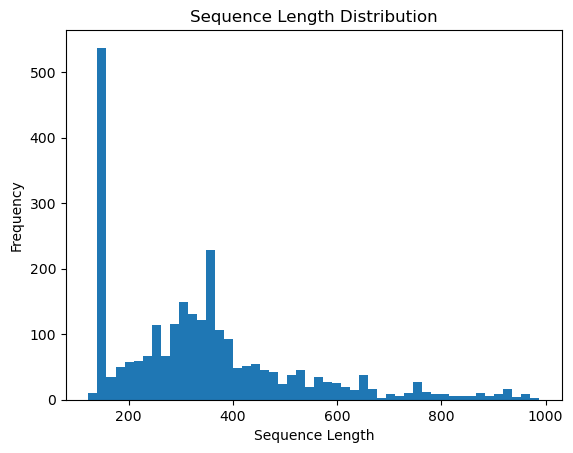

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_sequence_length_histogram_from_df(df, sequence_column="sequence"):

    sequence_lengths = df[sequence_column].apply(len)
    plt.hist(sequence_lengths, bins=50)  # Adjust the number of bins as needed
    plt.xlabel("Sequence Length")
    plt.ylabel("Frequency")
    plt.title("Sequence Length Distribution")
    plt.show()

df_unique = df_mmseqs2_esm2_unimol.drop_duplicates(subset='UniprotID')
plot_sequence_length_histogram_from_df(df_unique)

### Characterizing substrate landscape

Number of unique clusters: 1719


([], [])

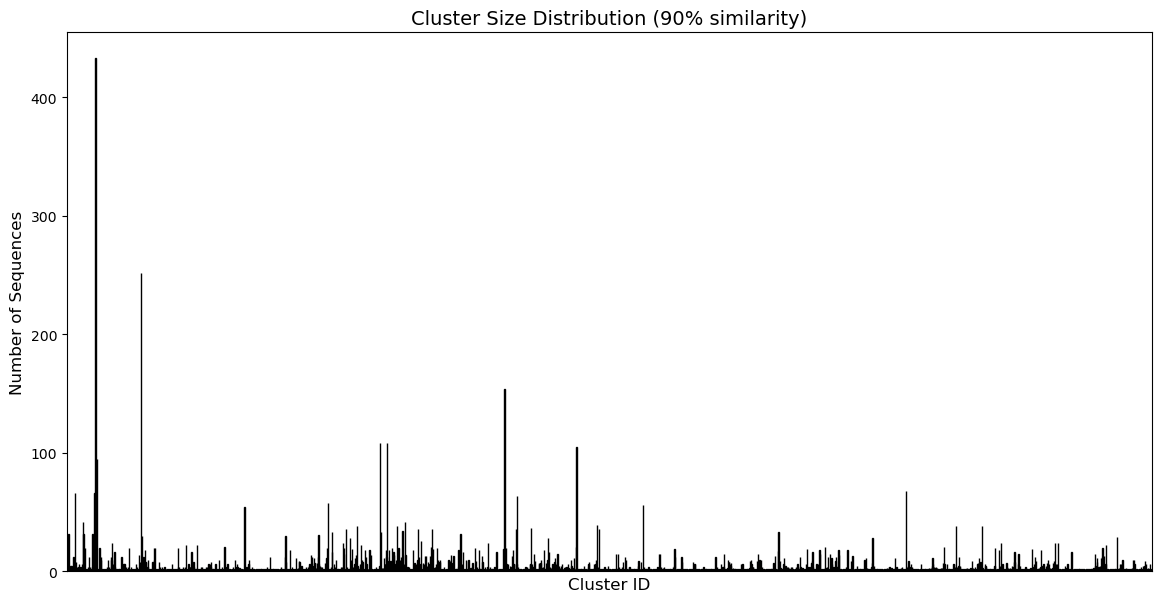

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# Number of unique clusters
num_unique_clusters = df_mmseqs2_esm2_unimol['mmseqs_representative_cluster_seq_0p9_similarity'].nunique()
print(f"Number of unique clusters: {num_unique_clusters}")

# Cluster size distribution
cluster_counts = df_mmseqs2_esm2_unimol.groupby('mmseqs_representative_cluster_seq_0p9_similarity').size()

plt.figure(figsize=(14, 7))
cluster_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Cluster Size Distribution (90% similarity)', fontsize=14)
plt.xlabel('Cluster ID', fontsize=12)
plt.ylabel('Number of Sequences', fontsize=12)
plt.xticks([])  # remove x-tick labels
#plt.show()

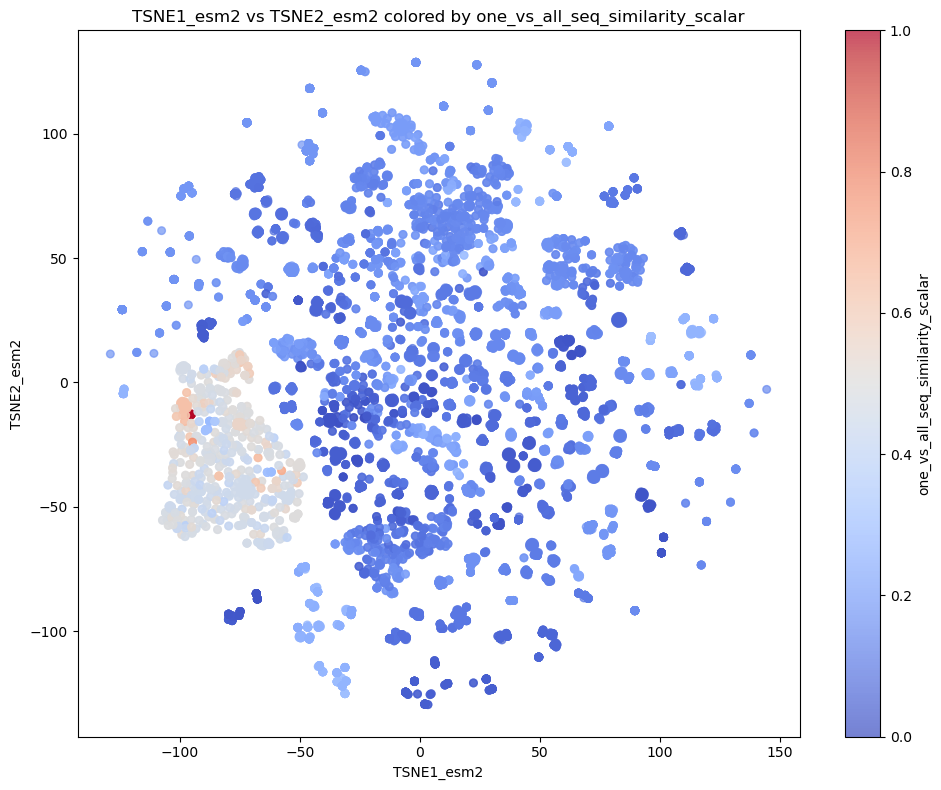

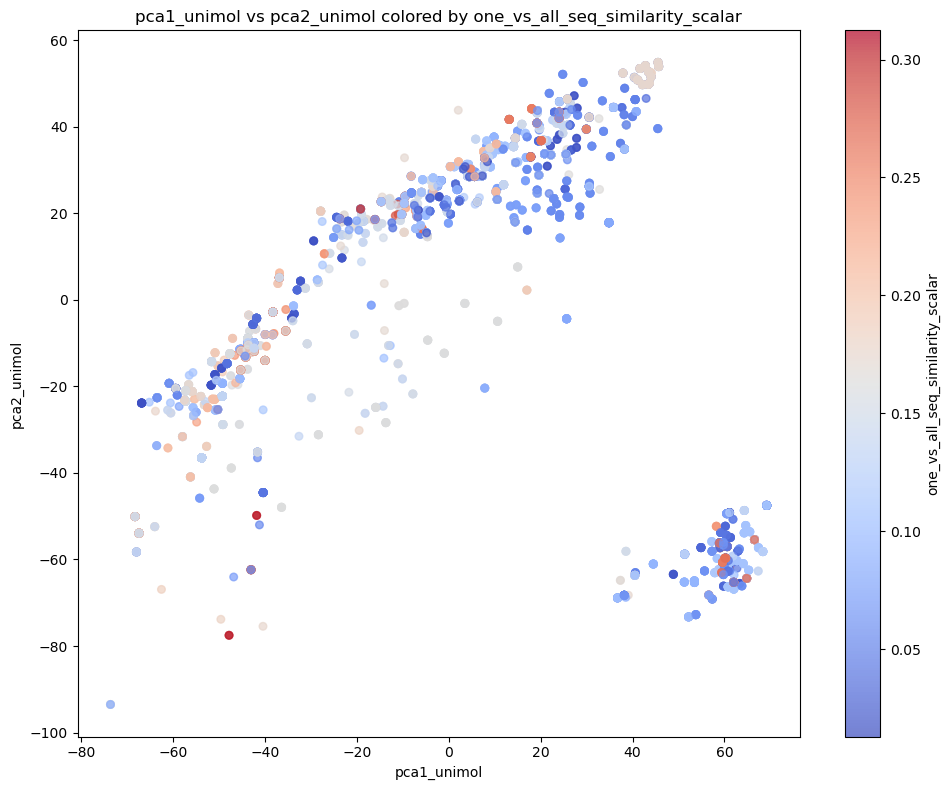

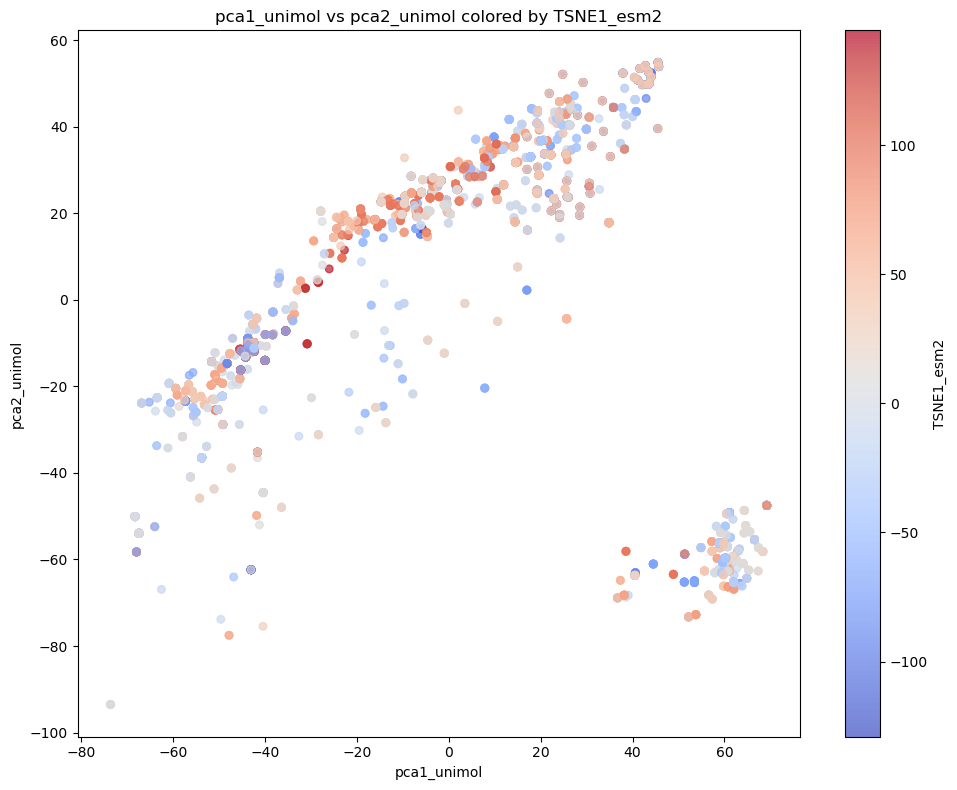

In [59]:
def plot_embedding_colored_by_property(df, x='UMAP1_esm2', y='UMAP2_esm2', color_by='mds1'):
    """
    Plot UMAP/t-SNE/PCA reduced embeddings colored by mmseqs2 cluster sequence similarity.
    """
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(df[x], df[y], c=df[color_by], cmap='coolwarm', s=30, alpha=0.7)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(f'{x} vs {y} colored by {color_by}')
    plt.colorbar(scatter, label=color_by)
    plt.tight_layout()
    plt.show()

plot_embedding_colored_by_property(df_mmseqs2_esm2_unimol, x='TSNE1_esm2', y='TSNE2_esm2', color_by='one_vs_all_seq_similarity_scalar')
plot_embedding_colored_by_property(df_mmseqs2_esm2_unimol, x='pca1_unimol', y='pca2_unimol', color_by='one_vs_all_seq_similarity_scalar')
plot_embedding_colored_by_property(df_mmseqs2_esm2_unimol, x='pca1_unimol', y='pca2_unimol', color_by='TSNE1_esm2')

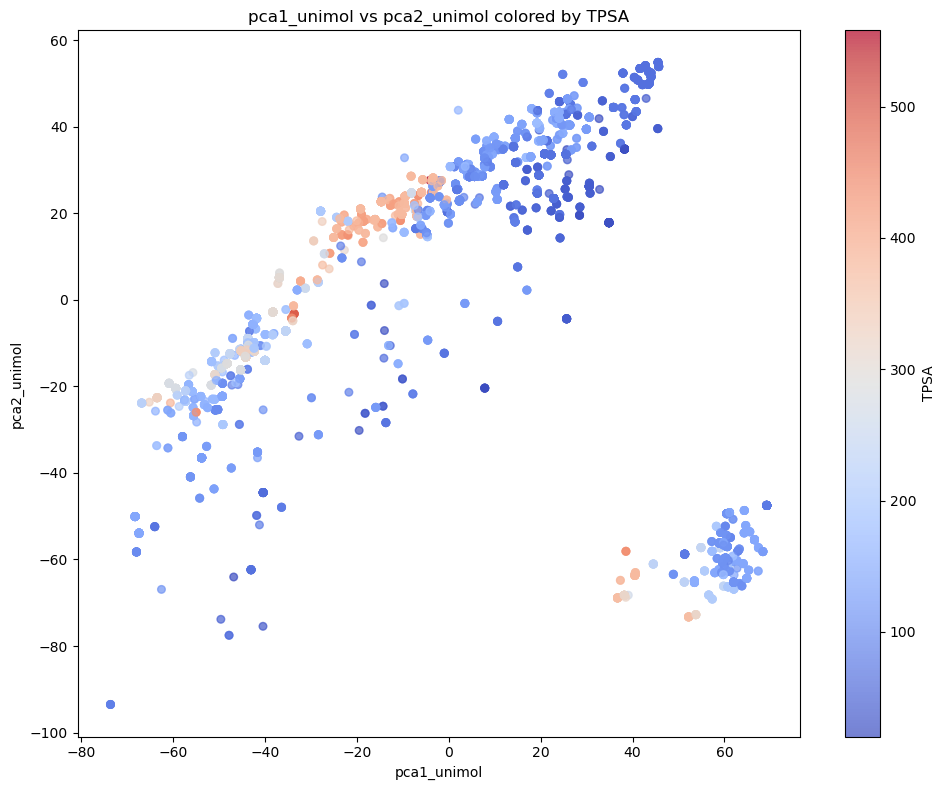

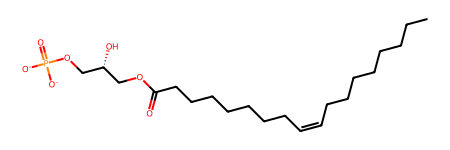

In [140]:
# Dimensionality reduced substrate embeddings colored by molecular descriptors

plot_embedding_colored_by_property(df_mmseqs2_esm2_unimol, x='pca1_unimol', y='pca2_unimol', color_by='TPSA')

filtered_df = df_mmseqs2_esm2_unimol[(df_mmseqs2_esm2_unimol['pca1_unimol'] > -20) & (df_mmseqs2_esm2_unimol['pca2_unimol'] > 10)]
unique_filtered_df = filtered_df.drop_duplicates(subset='substrates_split').reset_index(drop=True)
smile_string = unique_filtered_df.substrates_split[111]

# Take a look at the substrates
from rdkit import Chem
Chem.MolFromSmiles(smile_string)


/tmp/ipykernel_76659/3656300734.py:69: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title = 'Euclidian distance between centroids of UniMol embeddings averaged per MMseqs2 clusters',


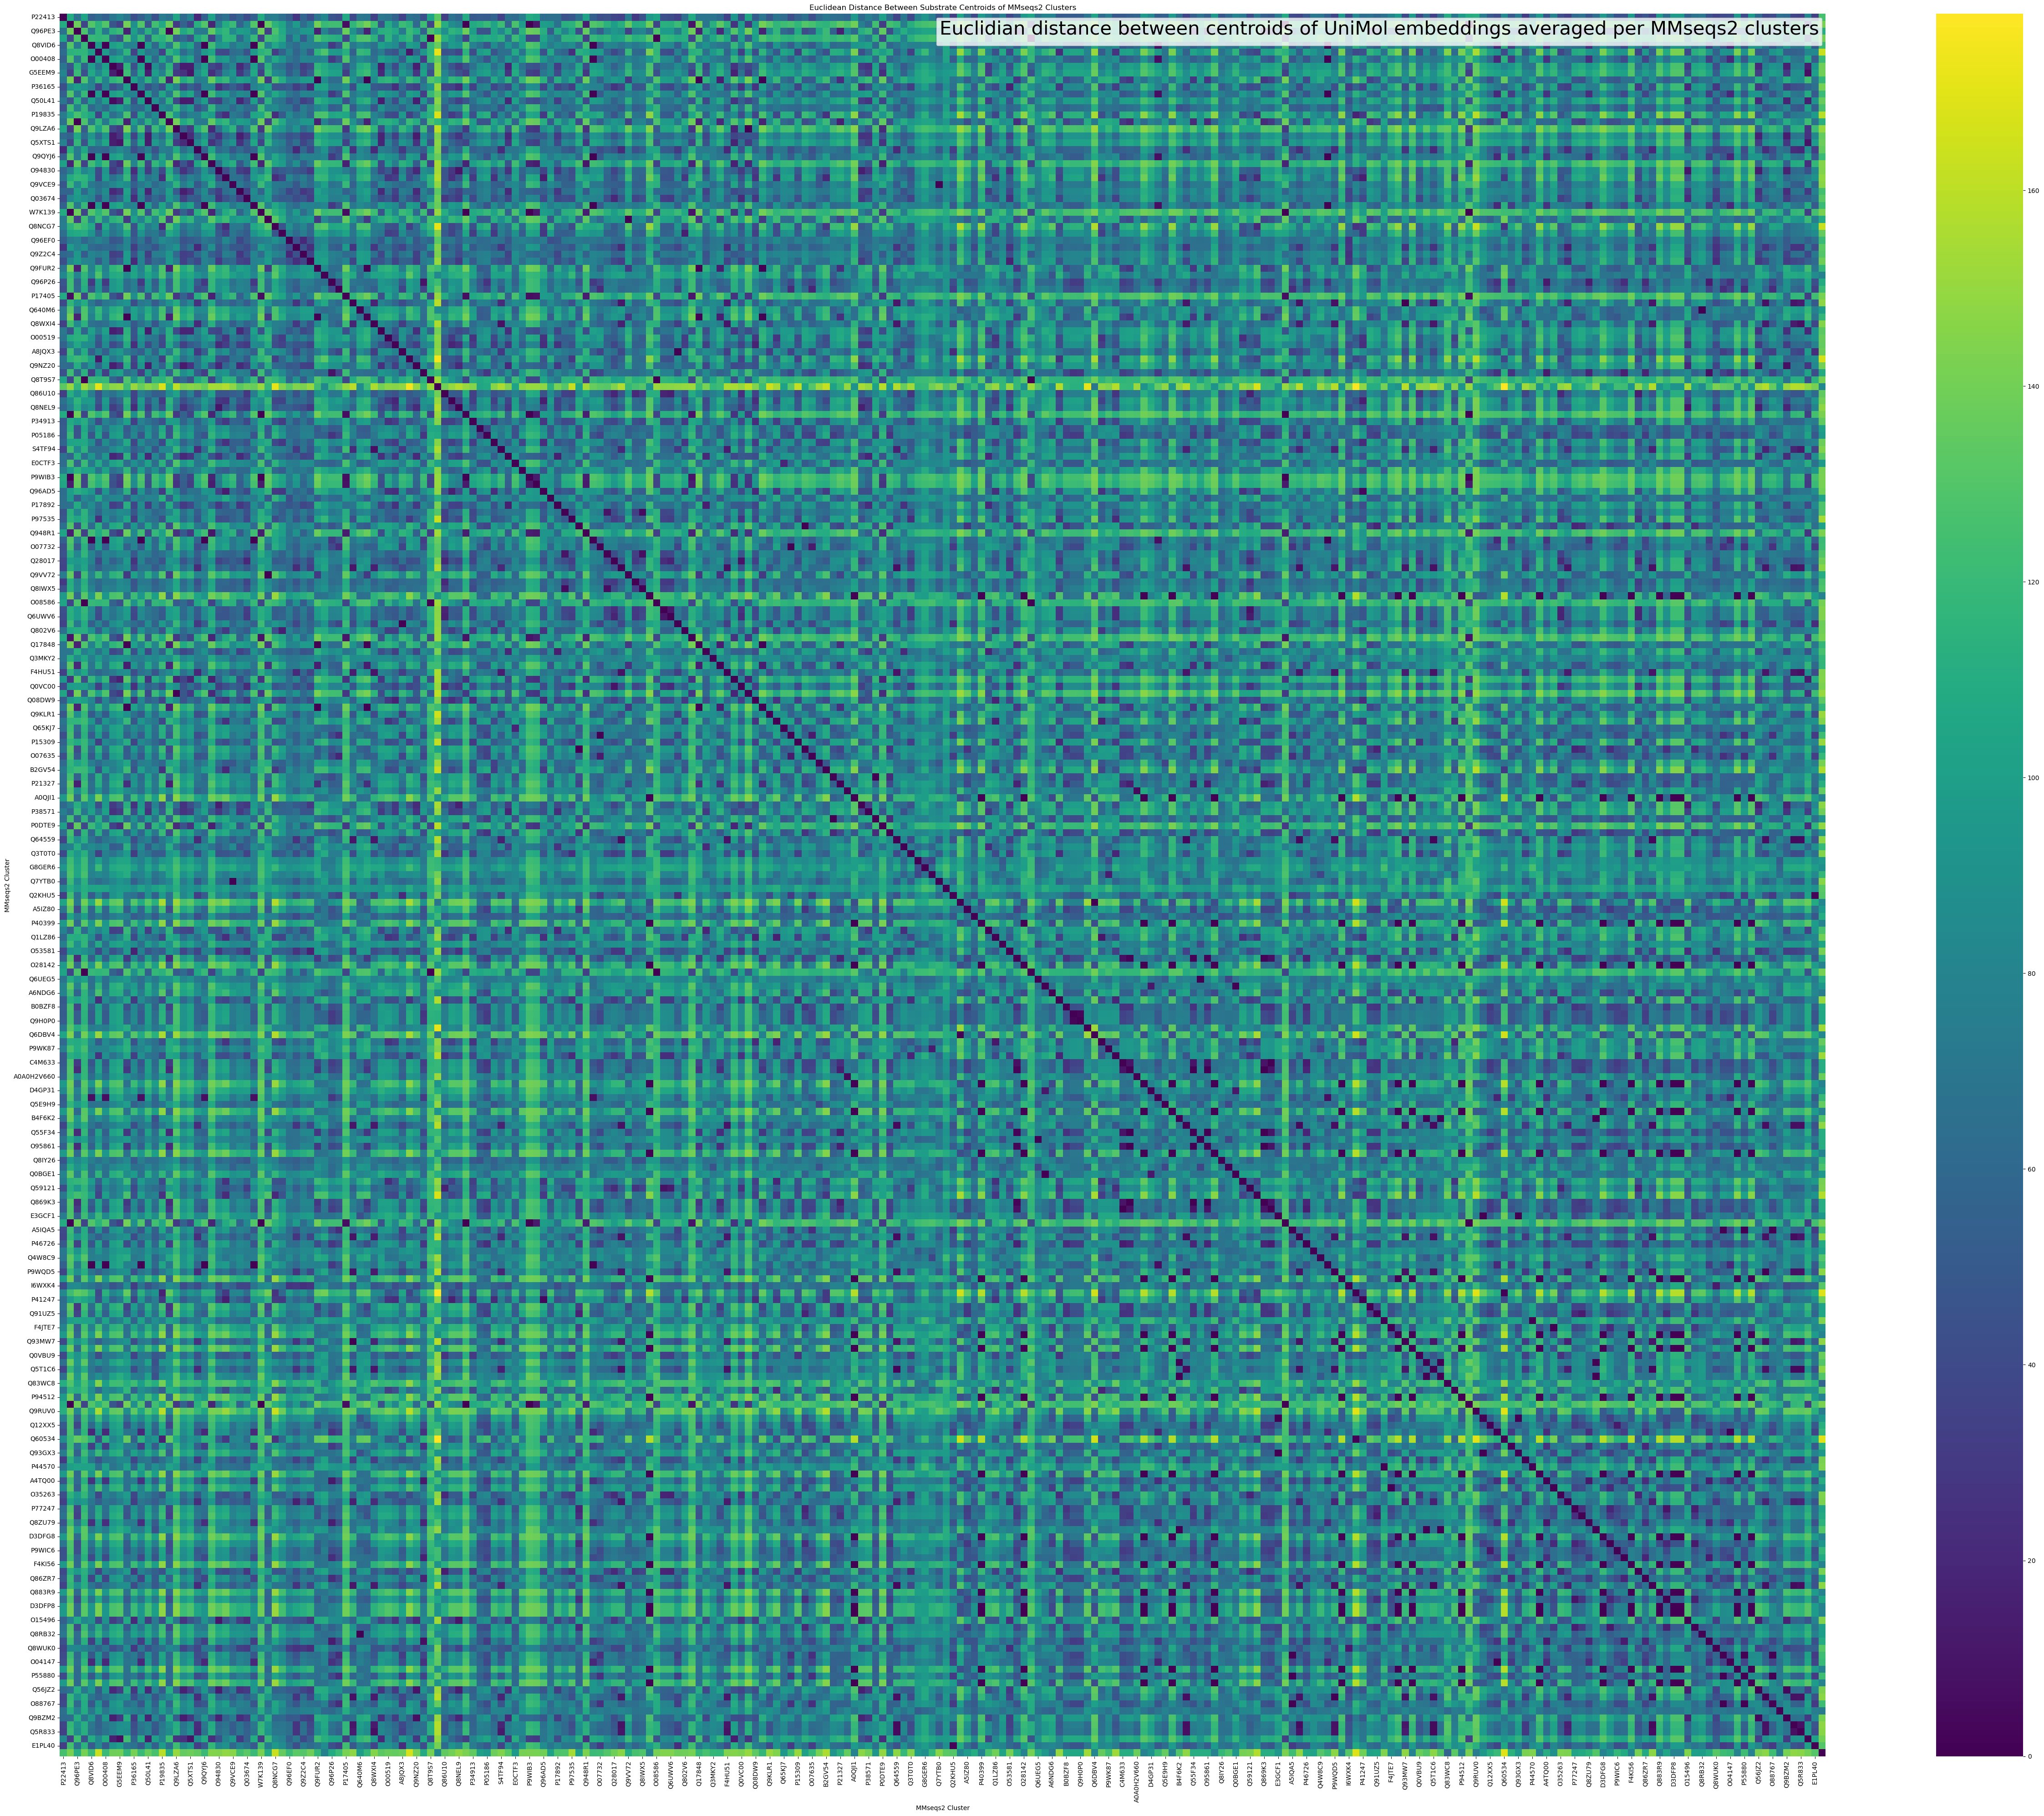

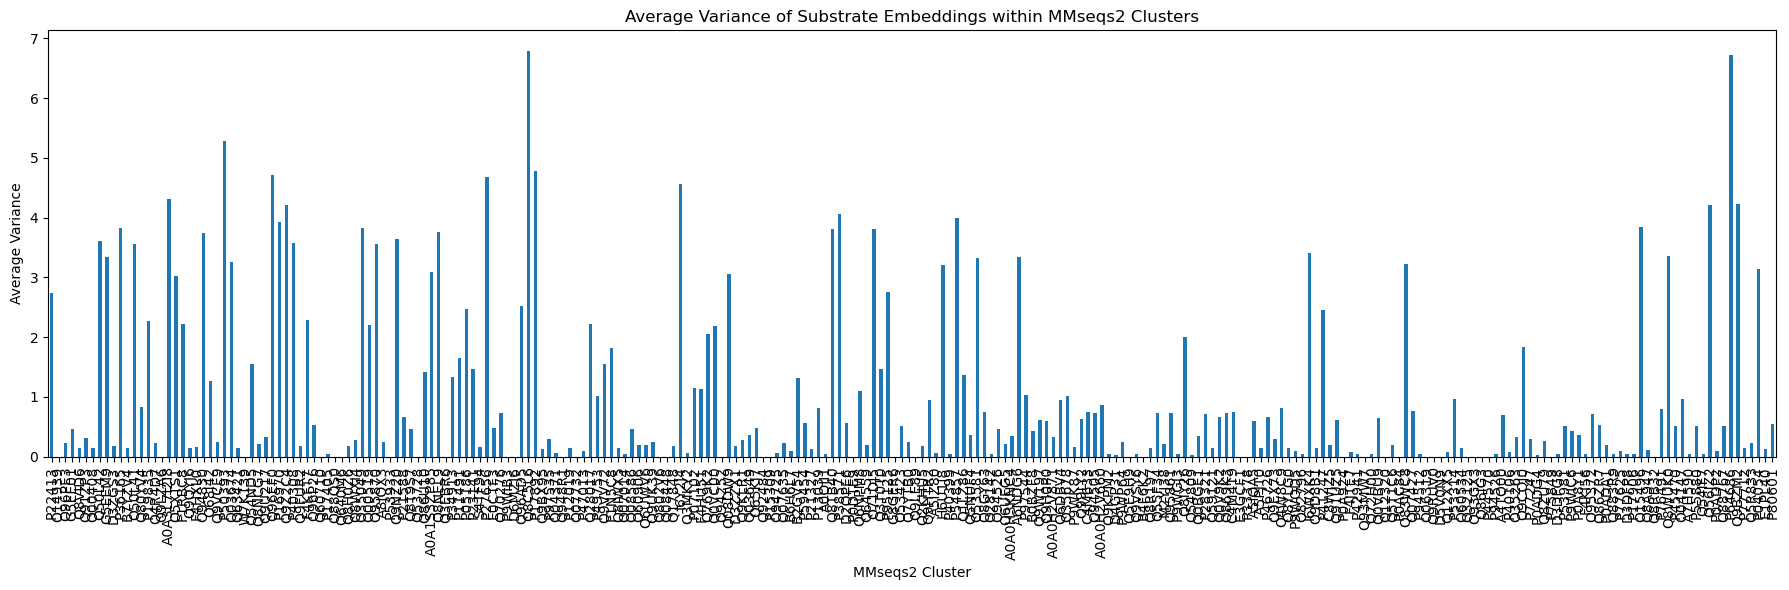

In [ ]:
# Quantitative analysis of substrate similarity within MMseqs2 clusters

import pandas as pd
import numpy as np
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
import seaborn as sns

def quantitative_substrate_analysis(df, embedding_column='unimol_repr', cluster_column='mmseqs_representative_cluster_seq_0p9_similarity'):
    """
    Calculates centroid distances and variances for visualization.
    """
    grouped = df.groupby(cluster_column)[embedding_column].apply(list)
    cluster_centroids = {}
    cluster_variances = {}
    for cluster, embeddings_list in grouped.items():
        if embeddings_list:
            valid_embeddings = []

            for emb in embeddings_list:
                # Unwrap list if necessary (i.e. [np.ndarray] → np.ndarray)
                if isinstance(emb, list) and len(emb) == 1 and isinstance(emb[0], np.ndarray):
                    emb = emb[0]

                # Check if it's a valid NumPy array
                if isinstance(emb, np.ndarray) and emb.size > 0:
                    flat = emb.flatten()
                    if not np.any(np.isnan(flat)) and not np.any(np.isinf(flat)):
                        valid_embeddings.append(flat)

            # Only compute if valid embeddings exist
            if valid_embeddings:
                embeddings_array = np.vstack(valid_embeddings)  # stack all vectors
                cluster_centroids[cluster] = np.mean(embeddings_array, axis=0)
                cluster_variances[cluster] = np.mean(np.var(embeddings_array, axis=0))
            else:
                cluster_variances[cluster] = np.nan


    clusters = list(cluster_centroids.keys())
    distance_matrix = pd.DataFrame(index=clusters, columns=clusters)
    for i, cluster1 in enumerate(clusters):
        for j, cluster2 in enumerate(clusters):
            if cluster1 in cluster_centroids and cluster2 in cluster_centroids:
                dist = euclidean(cluster_centroids[cluster1], cluster_centroids[cluster2])
                distance_matrix.loc[cluster1, cluster2] = dist
            else:
                distance_matrix.loc[cluster1, cluster2] = np.nan

    variance_df = pd.Series(cluster_variances, name='Average Variance')
    return distance_matrix, variance_df


distance_matrix, variance_df = quantitative_substrate_analysis(df_mmseqs2_esm2_unimol, cluster_column='mmseqs_representative_cluster_seq_0p6_similarity')

# Group by cluster according to sequence similarity between clusters
cluster_similarities = df_mmseqs2_esm2_unimol.groupby('mmseqs_representative_cluster_seq_0p9_similarity')['one_vs_all_seq_similarity_scalar'].mean()
sorted_clusters = cluster_similarities.sort_values().index.tolist()
filtered_clusters = [x for x in sorted_clusters if x in distance_matrix.index]
distance_matrix = distance_matrix.loc[filtered_clusters, filtered_clusters]
variance_df = variance_df.loc[filtered_clusters]

# Heatmap of Centroid Distances
plt.figure(figsize=(50, 40))
sns.heatmap(distance_matrix.astype(float), annot=False, cmap='viridis', fmt=".2f")
plt.title('Euclidean Distance Between Substrate Centroids of MMseqs2 Clusters')
plt.xlabel('MMseqs2 Cluster')
plt.ylabel('MMseqs2 Cluster')
plt.legend(title = 'Euclidian distance between centroids of UniMol embeddings averaged per MMseqs2 clusters', 
    fontsize = 'large', 
    title_fontsize = '30')
plt.tight_layout()
plt.show()


# Bar Chart of Cluster Variance
plt.figure(figsize=(18, 6))
variance_df.plot(kind='bar')
plt.title('Average Variance of Substrate Embeddings within MMseqs2 Clusters')
plt.xlabel('MMseqs2 Cluster')
plt.ylabel('Average Variance')
plt.tight_layout()
plt.show()

# The centroid gives you a central "average" UniMol embedding for the substrates associated with each enzyme cluster.
# The average variance gives you a measure of how spread out the substrate embeddings are within each cluster. 
# A lower variance suggests that the substrates of enzymes in that cluster are more structurally similar to each other (according to UniMol).

# The Euclidean distance  between the centroids of two different clusters gives you an idea 
# of how structurally similar the average preferred substrates are for those two enzyme clusters. 
# Smaller distances suggest more similar average substrate preferences.


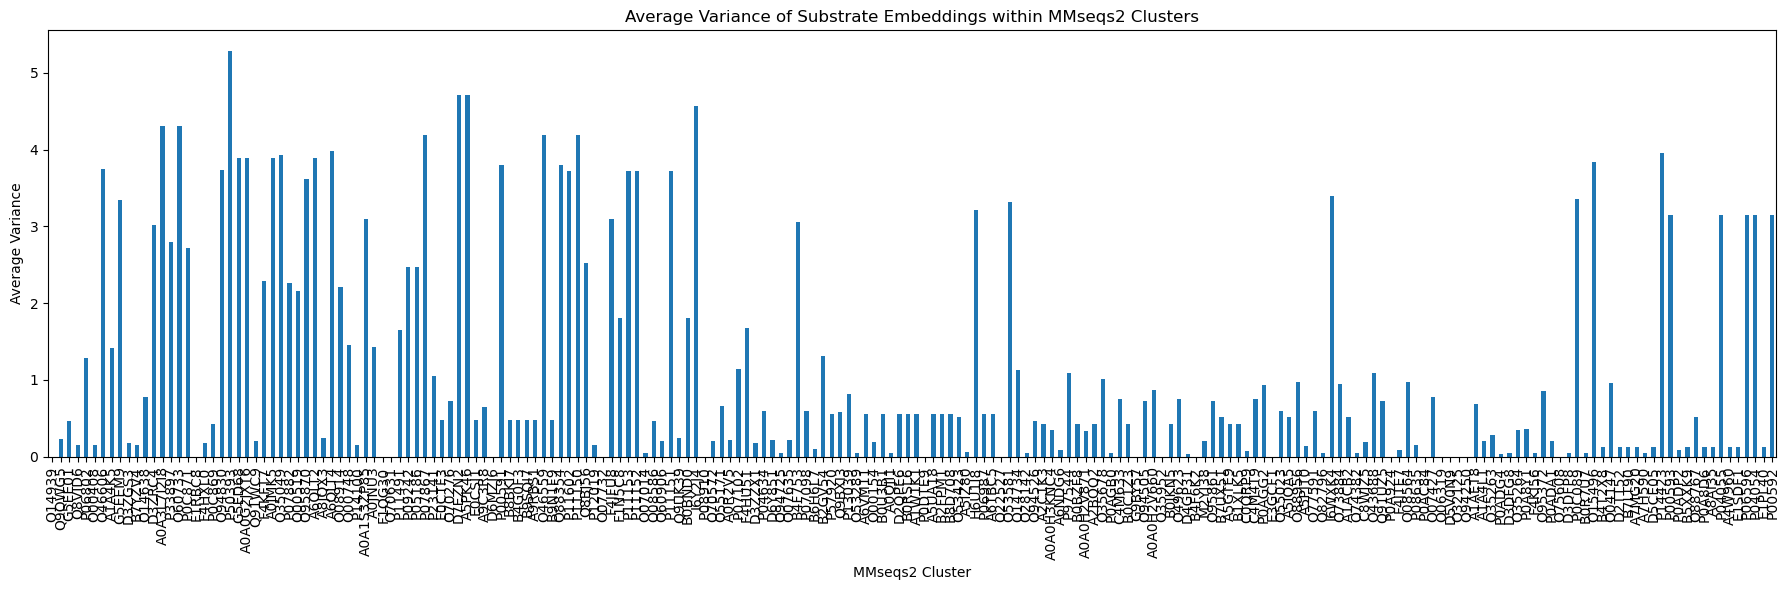

In [154]:
# Bar Chart of Cluster Variance
plt.figure(figsize=(18, 6))
variance_df.plot(kind='bar')
plt.title('Average Variance of Substrate Embeddings within MMseqs2 Clusters')
plt.xlabel('MMseqs2 Cluster')
plt.ylabel('Average Variance')
plt.tight_layout()
plt.show()